# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [13]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 194 records>]
[<FluxTable: 12 columns, 483 records>, <FluxTable: 12 columns, 194 records>]
[<FluxTable: 12 columns, 483 records>]


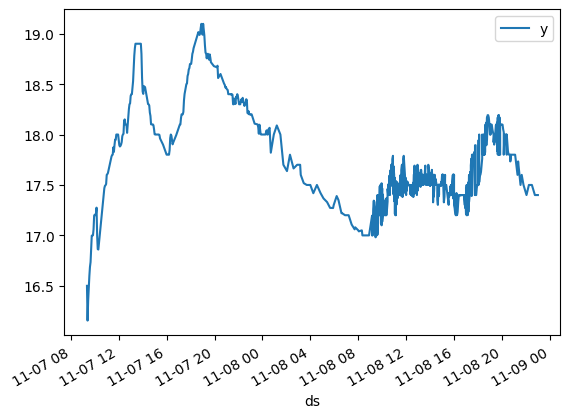

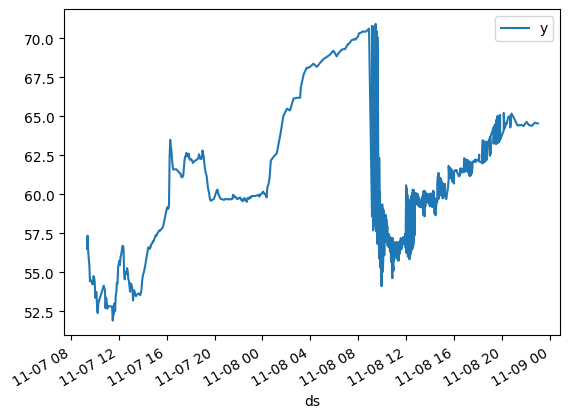

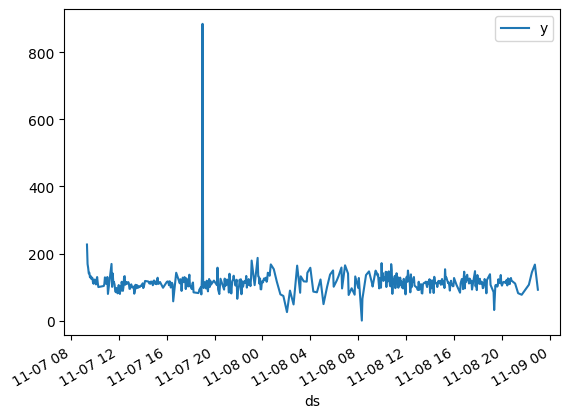

In [14]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-11-07T09:00:00.00Z, stop: 2022-11-09T09:00:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+ bucket + '")' \
                ' |> aggregateWindow(every: 3m, fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [15]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
global tempDate
global humDate
global gasDate

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.80)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]
    tempDate = dfTemp ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    tempDate['ds'] = tempDate.ds.dt.floor('min')

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.80)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]
    humDate = dfHum ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')   

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.80)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    gasDate = dfGas ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')

Temperature Dataset
   count       mean       std        min        25%        50%    75%  \
y  677.0  17.768232  0.487342  16.155556  17.408333  17.605556  18.09   

         max  
y  19.097222  
Humidity Dataset
   count       mean       std        min        25%        50%        75%  \
y  677.0  60.046031  3.729292  51.916364  57.138889  59.942334  62.141667   

       max  
y  70.9375  
Gas Dataset
   count        mean        std  min         25%         50%         75%  \
y  483.0  114.395033  40.873204  0.0  102.159722  112.583333  123.041667   

          max  
y  885.068966  


### Check if the time-series are stationary using the Dickey-Fuller test

In [16]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -3.099613
TEMPERATURE: p-value: 0.026582
HUMIDITY: ADF Statistic: -2.859887
HUMIDITY: p-value: 0.050215
GAS: ADF Statistic: -18.567036
GAS: p-value: 0.000000


### If P Value > 0.05 we go ahead with finding the order of differencing.

TEMPERATURE: ADF Statistic: -6.041658
TEMPERATURE: new p-value: 0.000000


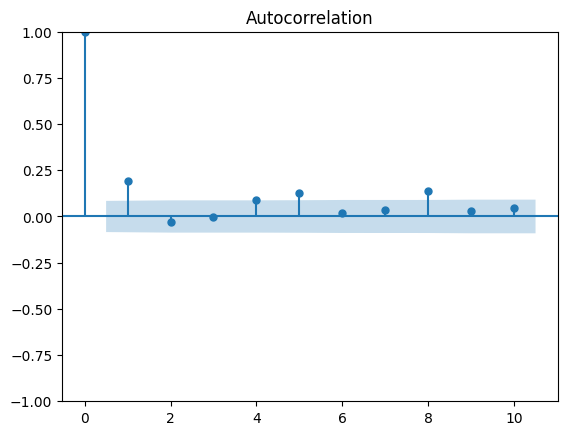

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



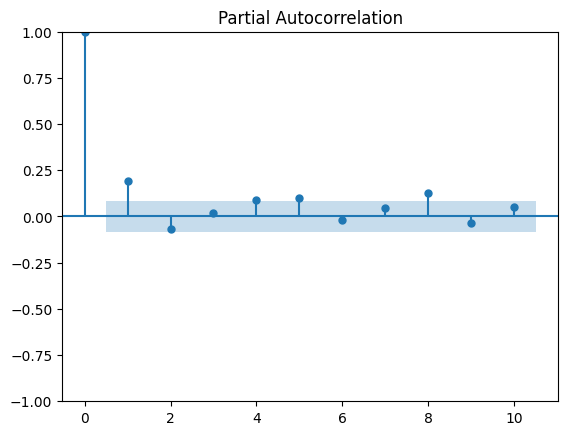

HUMIDITY: ADF Statistic: -5.739334
HUMIDITY: new p-value: 0.000001


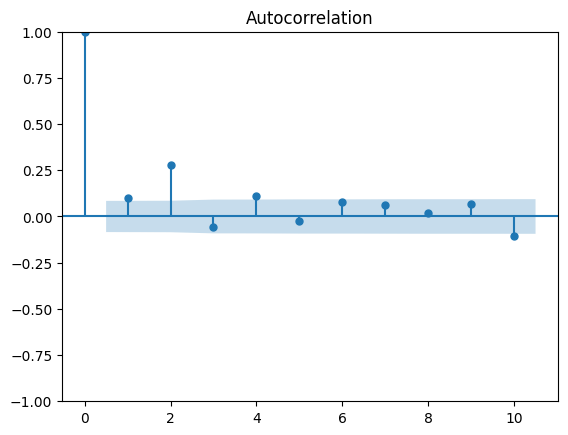

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



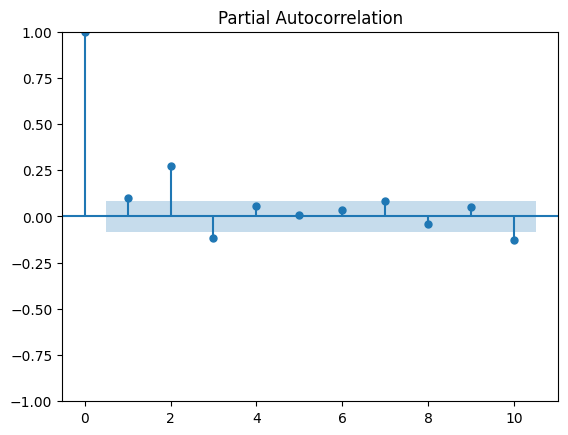

GAS: ADF Statistic: -8.922532
GAS: new p-value: 0.000000


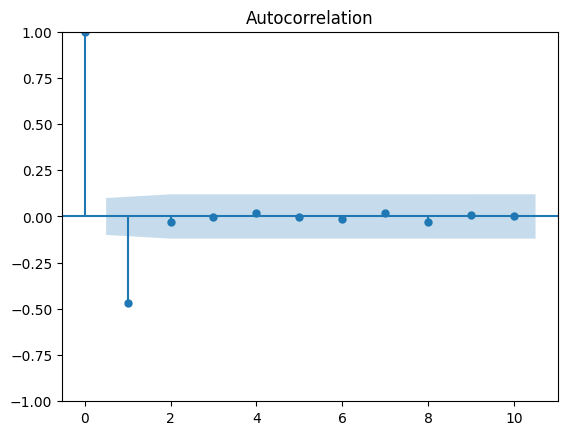

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



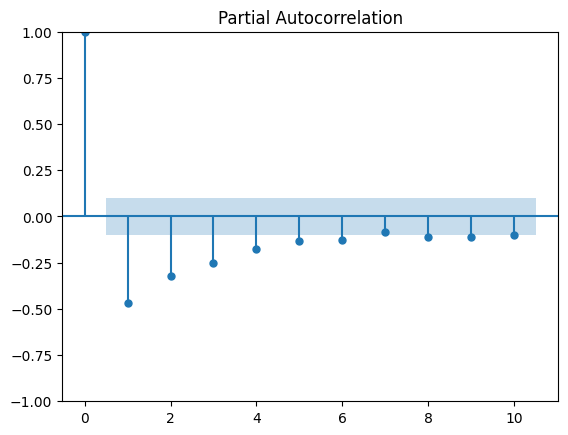

In [17]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty):
    aux = trainTemp
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty):
    aux = trainHum
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty):
    aux = trainGas
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
#ARIMA(p,d,q)

global temp_model_fit
global hum_model_fit
global gas_model_fit

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,1,0))
    temp_model_fit = model.fit()
    output = temp_model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(1,1,1))
    hum_model_fit = model.fit()
    output = hum_model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(0,1,0))
    gas_model_fit = model.fit()
    output = gas_model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.500000, expected=17.497222
predicted=17.497222, expected=17.480556
predicted=17.480556, expected=17.497059
predicted=17.497059, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.523333
predicted=17.523333, expected=17.605556
predicted=17.605556, expected=17.691667
predicted=17.691667, expected=17.605556
predicted=17.605556, expected=17.600000
predicted=17.600000, expected=17.600000
predicted=17.600000, expected=17.597222
predicted=17.597222, expected=17.700000
predicted=17.700000, expected=17.652778
predicted=17.652778, expected=17.600000
predicted=17.600000, expected=17.597222
predicted=17.597222, expected=17.600000
predicted=17.600000, expected=17.625000
predicted=17.625000, expected=17.650000
predicted=17.650000, expected=17.605556
predicted=17.605556, expected=17.600000
predicted=17.600000, expected=17.591667
predicted=17.591667, expected=17.600000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.561111, expected=17.527778
predicted=17.527778, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.505556
predicted=17.505556, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.488889
predicted=17.488889, expected=17.497222
predicted=17.497222, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.497222
predicted=17.497222, expected=17.327778
predicted=17.327778, expected=17.383333
predicted=17.383333, expected=17.463889
predicted=17.463889, expected=17.500000
predicted=17.500000, expected=17.500000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.500000, expected=17.357143
predicted=17.357143, expected=17.302778
predicted=17.302778, expected=17.386111
predicted=17.386111, expected=17.403571
predicted=17.403571, expected=17.488889
predicted=17.488889, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.533333
predicted=17.533333, expected=17.600000
predicted=17.600000, expected=17.605556
predicted=17.605556, expected=17.600000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.600000, expected=17.420000
predicted=17.420000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.397222
predicted=17.397222, expected=17.363889
predicted=17.363889, expected=17.300000
predicted=17.300000, expected=17.270000
predicted=17.270000, expected=17.211111


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.211111, expected=17.200000
predicted=17.200000, expected=17.200000
predicted=17.200000, expected=17.202778
predicted=17.202778, expected=17.233333
predicted=17.233333, expected=17.330556
predicted=17.330556, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.394444
predicted=17.394444, expected=17.394444
predicted=17.394444, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.400000
predicted=17.400000, expected=17.472222
predicted=17.472222, expected=17.500000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.527778
predicted=17.527778, expected=17.597222
predicted=17.597222, expected=17.600000
predicted=17.600000, expected=17.629630
predicted=17.629630, expected=17.694444
predicted=17.694444, expected=17.761111
predicted=17.761111, expected=17.800000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.827778
predicted=17.827778, expected=17.893103
predicted=17.893103, expected=17.894444
predicted=17.894444, expected=17.945161
predicted=17.945161, expected=18.000000
predicted=18.000000, expected=18.000000
predicted=18.000000, expected=17.923529
predicted=17.923529, expected=17.900000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.900000, expected=18.009091
predicted=18.009091, expected=18.094118
predicted=18.094118, expected=18.102778
predicted=18.102778, expected=18.119444
predicted=18.119444, expected=18.169444
predicted=18.169444, expected=18.191667
predicted=18.191667, expected=18.191667
predicted=18.191667, expected=18.169444
predicted=18.169444, expected=18.105556
predicted=18.105556, expected=18.100000
predicted=18.100000, expected=18.100000
predicted=18.100000, expected=18.100000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=18.100000, expected=18.097222
predicted=18.097222, expected=18.052778
predicted=18.052778, expected=18.022222
predicted=18.022222, expected=18.000000
predicted=18.000000, expected=18.000000
predicted=18.000000, expected=18.000000
predicted=18.000000, expected=18.000000
predicted=18.000000, expected=18.000000
predicted=18.000000, expected=17.925000
predicted=17.925000, expected=17.836111


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=17.836111, expected=17.802778
predicted=17.802778, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.800000
predicted=17.800000, expected=17.733333
predicted=17.733333, expected=17.600000
predicted=17.600000, expected=17.500000
predicted=17.500000, expected=17.500000
predicted=17.500000, expected=17.400000
predicted=59.719748, expected=59.333583
predicted=59.300663, expected=59.279520
predicted=59.251579, expected=59.273961
predicted=59.255418, expected=59.528818
predicted=59.549128, expected=59.929552
predicted=59.993150, expected=60.083073
predicted=60.143229, expected=60.314532
predicted=60.382392, expected=60.004603
predicted=60.008752, expected=60.283909
predicted=60.321874, expected=60.122417
predicted=60.126425, expected=59.942334
predicted=59.922180, expected=59.991590
predicted=59.984896, expected=60.079705


In [19]:
def send_predictions(df, date, bucket):
	lines = [str(df['y'][d]) for d in range(len(df))]
	if(bucket == "gas"):
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " gasPred" + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	else:
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

### ARIMA model evaluation (RMSE)

Test RMSE: 0.048


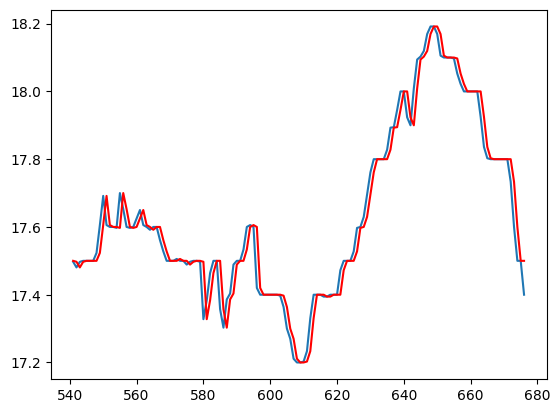

Test RMSE: 0.248


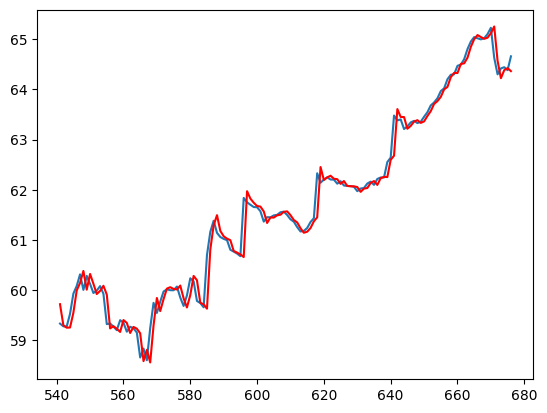

Test RMSE: 23.005


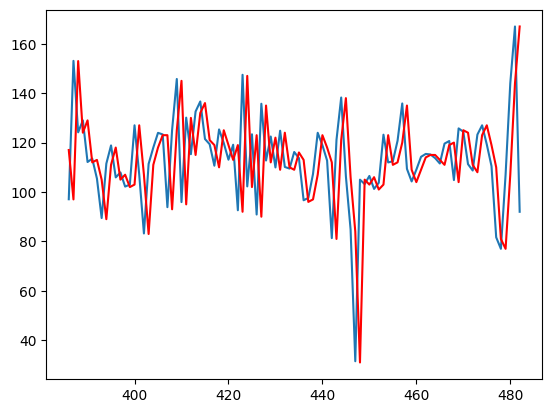

In [20]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsTemp)
  df.columns = ['y']
  send_predictions(df, tempDate, "temperature")
  df.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsHum)
  df.columns = ['y']
  send_predictions(df, humDate, "humidity")
  df.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df, color='red')
  plt.show()
  
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsGas)
  df.columns = ['y']
  df["y"] = df["y"].astype(int)
  send_predictions(df, gasDate, "gas")
  df.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df, color='red')
  plt.show()

### Evaluation

In [21]:
#Temperature evaluation
temp_forecast = temp_model_fit.get_forecast()
temp_forecast.summary_frame()
yhat = temp_forecast.predicted_mean
yhat_conf_int = temp_forecast.conf_int(alpha=0.05)

print('Temperature Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
hum_forecast = hum_model_fit.get_forecast()
hum_forecast.summary_frame()
yhat = hum_forecast.predicted_mean
yhat_conf_int = hum_forecast.conf_int(alpha=0.05)

print('Humidity Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
gas_forecast = gas_model_fit.get_forecast()
gas_forecast.summary_frame()
yhat = gas_forecast.predicted_mean
yhat_conf_int = gas_forecast.conf_int(alpha=0.05)

print('Gas Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))



Temperature Model Evaluation Summary:
----------------------------------------
Mean: [17.5]
Confidence Interval: [[17.37852565 17.62147435]]
Humidity Model Evaluation Summary:
----------------------------------------
Mean: [64.36236691]
Confidence Interval: [[63.3678261  65.35690772]]
Gas Model Evaluation Summary:
----------------------------------------
Mean: [167.]
Confidence Interval: [[ 57.92694014 276.07305986]]
